In [1]:
# 01 - Params

url_base = "https://www.twingalaxies.com/showthread.php/176004-Dispute-Jeremy-Young-Arcade-Donkey-Kong-Points-Hammer-Allowed-Player-Billy-L-Mitchell-Score-1-062-800/page"
file_name = "./twingalaxies_dispute_billymitchell.xls"
file_name_linklist = "./twingalaxies_dispute_billymitchell_linklist.csv"

# 02 - Definitions and imports

import urllib
import pandas as pd
import numpy as np
import bs4
import time
import re
import dateutil
import collections
import datetime
import networkx as nx
import operator
import matplotlib.pyplot as plt


def get_post_id(post_parent):
        #print(post_parent)
        try:
            post_counter = post_parent.find("a", {"class": "postcounter"})
            return post_counter.contents[0]
        except AttributeError:
            return None


def read_thread_df(file_name):
    try:
        all_loaded_df = pd.read_excel(file_name)
    except FileNotFoundError:
        return None
        
    for col_name in all_loaded_df.columns:
        if "_list" in col_name:
            all_loaded_df.loc[:, col_name] = all_loaded_df.loc[:, col_name].apply(lambda x: x.split(", ") if not pd.isnull(x) else [])

    return all_loaded_df


def write_thread_df(all_df, file_name):

    all_listasstrings_df = all_df.copy()

    for col_name in all_listasstrings_df.columns:
        if "_list" in col_name:
            all_listasstrings_df.loc[:, col_name] = all_listasstrings_df.loc[:, col_name].apply(lambda x: re.sub("\[|\]|\'", "", str(x)))

    all_listasstrings_df.to_excel(file_name, index=None)
    all_listasstrings_df.to_csv(file_name.replace("xls", "csv"), sep=";", quoting=2, encoding="utf-8", index=None)



def get_edgelist(all_df, col_name_list):
    df = all_df.copy().rename({"user_name": "to", col_name_list: "from"}, axis="columns").set_index(["to", "post_id"])
    likes_edgelist = (pd.melt(df["from"].apply(pd.Series).reset_index(), 
                                 id_vars=["to", "post_id"],
                                 value_name="from")
                         .set_index(["to", "post_id"])
                         .drop("variable", axis=1)
                         .dropna()
                         .sort_index()
                         )

    edgelist_noedgename = likes_edgelist.reset_index().groupby(["from", "to"]).count().rename({"post_id": "weight"}, axis= "columns").reset_index()
    edgelist_noedgename_indexed = edgelist_noedgename.set_index(["from", "to"])
    return edgelist_noedgename_indexed


def calc_poster_weight(thanks_likes_edgelist_noindex, weight_var):
    # Calculate graphe from edge list
    G = nx.from_pandas_dataframe(thanks_likes_edgelist_noindex, "from", "to", weight_var, create_using=nx.DiGraph())

    # Use centrality as proxy for poster weight = importance (by likes and thanks)
    centrality_nodes = nx.eigenvector_centrality(G, weight=weight_var)
    poster_weight_dict = collections.OrderedDict(sorted(centrality_nodes.items(), key=operator.itemgetter(1), reverse=True))
    poster_weight_series = pd.Series(poster_weight_dict)

    # Calculate poster weigths
    poster_weight_df = pd.DataFrame(poster_weight_series/(poster_weight_series.sum()), columns=["poster_weight_rel"])
    return poster_weight_df

In [2]:
## 03 - Calculate poster and post scores based on network centrality
## https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.algorithms.centrality.eigenvector_centrality.html

all_df = read_thread_df(file_name)

thanks_edgelist = get_edgelist(all_df, "thanks_list")
likes_edgelist = get_edgelist(all_df, "likes_list")

thanks_likes_edgelist = thanks_edgelist.join(likes_edgelist, how="outer", lsuffix="_thanks", rsuffix="_likes").fillna(0)
weight_sums = thanks_likes_edgelist.sum()
thanks_factor = weight_sums["weight_likes"]/weight_sums["weight_thanks"]

thanks_likes_edgelist["weight_total"] = thanks_factor*thanks_likes_edgelist["weight_thanks"] + thanks_likes_edgelist["weight_likes"]
thanks_likes_edgelist_noindex = thanks_likes_edgelist.reset_index()

poster_weight_df = calc_poster_weight(thanks_likes_edgelist_noindex, "weight_total")
    
poster_weight_df["poster_weight_abs"] = poster_weight_df["poster_weight_rel"]*weight_sums["weight_likes"]*2 + 1
poster_weight_df.index.names = ['user_name']

# Calculate how many likes/thanks were given by a particular person
thanks_likes_from = thanks_likes_edgelist.groupby("from").sum()#.set_index("from")
thanks_likes_from.index.names = ['user_name']
poster_weight_likes_thanks = poster_weight_df.join(thanks_likes_from, how="outer")
poster_weight_likes_thanks["likes_weight"] = (poster_weight_likes_thanks["poster_weight_abs"]/poster_weight_likes_thanks["weight_total"]).fillna(0)
poster_weight_likes_thanks["thanks_weight"] = poster_weight_likes_thanks["likes_weight"] * thanks_factor

# Finally, add post score and rank to the global df
all_df["post_score"] = (all_df["likes_list"].apply(lambda x: sum([poster_weight_likes_thanks.loc[y, "likes_weight"] for y in x]))
            + all_df["thanks_list"].apply(lambda x: sum([poster_weight_likes_thanks.loc[y, "thanks_weight"] for y in x])))

all_df["post_rank"] = all_df["post_score"].rank(ascending=False)

write_thread_df(all_df, file_name)
all_df.reset_index().sort_values("post_rank").head(5)

,index,post_id,post_time,url_post,user_name,post_score,post_rank,content,links_list,links_number,cites_list,cites_number,thanks_list,thanks_number,likes_list,likes_number
1425,1425,#1426,2018-02-22 13:09:00,https://www.twingalaxies.com/showthread.php/17...,Jace Hall,226.842902,1.0,For those that may have missed our previous up...,[https://www.twingalaxies.com/attachment.php?a...,5,[],0,"[Fendersonia, xelnia, JJT_Defender, Welp, TWIN...",10,"[homerwannabee, Fendersonia, sion fiction, Rob...",16
1568,1568,#1569,2018-02-28 03:13:00,https://www.twingalaxies.com/showthread.php/17...,J.C. Harrist,182.601695,2.0,This is the result of extensive testing shot a...,"[https://i.imgur.com/vgJ3gJM.jpg, https://i.im...",7,[],0,"[HugDD, Jace Hall, Snazzavich, xelnia, portman...",17,"[HugDD, Snazzavich, xelnia, portmanteau, grapp...",20
1096,1096,#1097,2018-02-13 20:34:00,https://www.twingalaxies.com/showthread.php/17...,Snowflake,164.339077,3.0,"well, although I knew walking in I was probabl...",[],0,[],0,[sprinter461],1,"[The Evener, thegamer1185, dwayne richard, kev...",5
3087,3087,#3088,2018-04-10 18:17:00,https://www.twingalaxies.com/showthread.php/17...,Andarin,132.994589,4.0,1) Contribution to thread \n This was quite a ...,"[https://www.youtube.com/watch?v=kpk2tdsPh0A, ...",16,[],0,"[francoisadt, YesAffinity, MrSteveFrench, sion...",17,"[YesAffinity, JJT_Defender, Robert.F, Rev John...",17
1201,1201,#1202,2018-02-16 18:08:00,https://www.twingalaxies.com/showthread.php/17...,ant3x7,129.566218,5.0,"First off, a quick introduction: \n I first he...","[https://youtu.be/0tJzMCIZzgQ, https://i.imgur...",23,[],0,"[paramylodon, gstrain, GiGinge420, TWIN GALAXIES]",4,[],0


<h3>Stats

In [3]:
## 04 - General poster statistics

participants_active = set(all_df["user_name"])
participants_passive = (set(thanks_edgelist.reset_index()["from"]) | set(likes_edgelist.reset_index()["from"])) - participants_active
print("Active posters: " + str(len(participants_active)))
print("Only likers/thankers: " + str(len(participants_passive)))

Active posters: 157
Only likers/thankers: 160


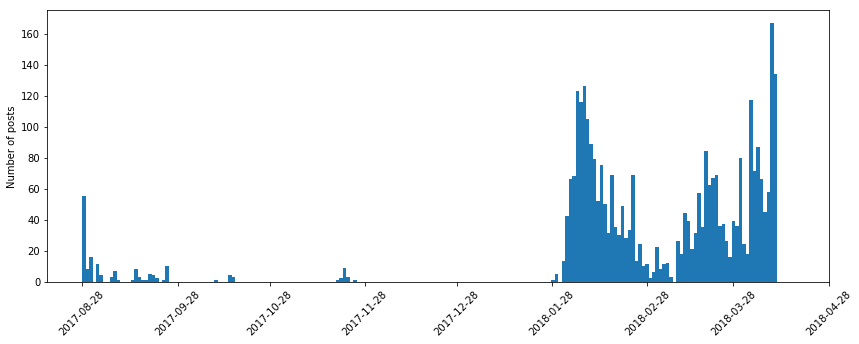

In [4]:
## 05 - Thread timeline

post_time_df = pd.DataFrame(all_df["post_time"].copy())
post_time_df["unix"] = post_time_df.astype(np.int64)/1000000000
post_time_df = post_time_df.set_index("post_time")

epoch = datetime.datetime.utcfromtimestamp(0)
ticks = [{"value": post_time_df.min()}]
ticks[0]["date"] = datetime.datetime.fromtimestamp(ticks[0]["value"])

while (ticks[-1]["value"] < post_time_df.max()).bool():
    ticks += [{"date": ticks[-1]["date"] + dateutil.relativedelta.relativedelta(months=1)}]
    ticks[-1]["value"] = (ticks[-1]["date"] - epoch).total_seconds()

ax = post_time_df.plot(kind='hist', figsize=[14,5], bins=200, rot=45, legend=False, xticks=[float(x["value"]) for x in ticks])
labels_new = [x["date"].strftime('%Y-%m-%d') for x in ticks]
ax.set_xticklabels(labels_new)
ax.set_ylabel("Number of posts")

plt.show()

In [5]:
## 06 - MVP : Most valuable posters - absolute and relative to number of posts

file_name_userimportance_total = "./twingalaxies_dispute_billymitchell_userimportance_total.csv"
file_name_userimportance_perpost = "./twingalaxies_dispute_billymitchell_userimportance_bypost.csv"

# Absolute most valuable posters
poster_weight_df.reset_index().drop("poster_weight_abs", axis="columns").rename({"poster_weight_rel": "poster_weight_abs"}, axis="columns").to_csv(file_name_userimportance_total, sep=";", quoting=2, encoding="utf-8", index=None)

poster_weight_df.drop("poster_weight_abs", axis="columns").head(10)

,poster_weight_rel
user_name,
Jace Hall,0.136179
FBX,0.066991
RTM,0.050606
YesAffinity,0.046892
The Evener,0.044163
WCopeland,0.040626
Snowflake,0.029482
bh_,0.027535
xelnia,0.022401


In [6]:
## VP : Most valuable posters - Relative to number of posts
post_number_df = all_df.groupby("user_name").agg({"post_id": "count"}).reset_index().rename({"user_name": "to", "post_id": "post_number"}, axis="columns")

thanks_likes_edgelist_noindex_posts = thanks_likes_edgelist_noindex.merge(post_number_df, on=["to"], how="left")
thanks_likes_edgelist_noindex_posts["weight_total_per_post"] = thanks_likes_edgelist_noindex_posts["weight_total"] / thanks_likes_edgelist_noindex_posts["post_number"]

poster_weight_per_post_df = calc_poster_weight(thanks_likes_edgelist_noindex_posts, "weight_total_per_post")
poster_weight_per_post_df.reset_index().rename({"poster_weight_rel": "poster_weight_per_post"}, axis="columns").to_csv(file_name_userimportance_perpost, sep=";", quoting=2, encoding="utf-8", index=None)

poster_weight_per_post_df.head(10)

,poster_weight_rel
Andarin,0.179518
TWIN GALAXIES,0.061088
xelnia,0.028283
Omnigamer,0.022141
ersatz_cats,0.021185
WCopeland,0.020471
J.C. Harrist,0.020408
CaptainJivePants,0.020253
dwwnp,0.020239
Jace Hall,0.020211


In [7]:
## 07 - Most valuable links

all_df = read_thread_df("/home/andarin/Programming/twingalaxies_dispute_billymitchell.xls")
link_df = (pd.DataFrame(
            [(link, array[1]) for array in all_df[["links_list", "post_score"]].values for link in array[0]])
             .rename({0: "link", 1: "score"}, axis="columns")
             .groupby("link").agg({"score": sum})
             .reset_index()
             .sort_values("score", ascending=False)
            )

link_df.to_csv(file_name_linklist, sep=";", quoting=2, encoding="utf-8", index=None)

print("Number of links: " + str(link_df.shape[0]))

link_df.head(10)

Number of links: 1485


,link,score
72,https://d2inm5i7oiogt5.cloudfront.net/images/m...,7272.678100
71,https://d2inm5i7oiogt5.cloudfront.net/images/m...,7211.342166
39,http://pro.jvc.com/prof/attributes/tech_desc.j...,227.442808
735,https://www.twingalaxies.com/attachment.php?at...,226.842902
738,https://www.twingalaxies.com/attachment.php?at...,226.842902
737,https://www.twingalaxies.com/attachment.php?at...,226.842902
736,https://www.twingalaxies.com/attachment.php?at...,226.842902
1214,https://www.twingalaxies.com/member.php?u=43346,223.595523
1196,https://www.twingalaxies.com/member.php?u=31832,194.846236
260,https://i.imgur.com/eczstjG.jpg,182.601695
